In [1]:
using Plots
using DataStructures
using LibSndFile
pyplot()

Plots.PyPlotBackend()

In [2]:
abstract type InternalFilter end

In [3]:
mutable struct CombFilter <: InternalFilter
    g::Float64
    c::Float64
    τ::Int
    buff::CircularBuffer{Float64}
end

function CombFilter(g, c, τsec, fs)
    fs = trunc(Int, fs)
    τ = trunc(Int, τsec * fs)
    τ >= fs && (τ = fs - 1)
    buff = CircularBuffer{Float64}(fs)
    append!(buff, fill(0., capacity(buff)))
    
    return CombFilter(g, c, τ, buff)
end

function process!(self::CombFilter, u::Float64)
    d = self.buff[end - self.τ]
    v = self.g * d + u
    push!(self.buff, v)
    y = self.c * d
    
    return y
end

process! (generic function with 1 method)

In [4]:
mutable struct AllPassFilter <: InternalFilter
    g::Float64
    τ::Int
    buff::CircularBuffer{Float64}
end

function AllPassFilter(g, τsec, fs)
    fs = trunc(Int, fs)
    τ = trunc(Int, τsec * fs)
    τ >= fs && (τ = fs - 1)
    buff = CircularBuffer{Float64}(fs)
    append!(buff, fill(0., capacity(buff)))
    
    return AllPassFilter(g, τ, buff)
end

function process!(self::AllPassFilter, u::Float64)
    d = self.buff[end - self.τ]
    v = u + self.g * d
    push!(self.buff, v)
    y = -self.g * v + d
    
    return y
end

process! (generic function with 2 methods)

In [5]:
function clearBuff!(self::InternalFilter)
    T    = eltype(self.buff)
    N    = capacity(self.buff)
    buff = CircularBuffer{T}(N)
    append!(buff, fill(T(0), N))
    self.buff = buff
end

clearBuff! (generic function with 1 method)

In [6]:
mutable struct Reverbrator
    combs::Vector{CombFilter}
    apfs::Vector{AllPassFilter}
    wet::Float64
    fs::Float64
end

function Reverbrator(fs)
    combs = Vector{CombFilter}(0)
    apfs  = Vector{AllPassFilter}(0)
    wet   = 0.5
    
    return Reverbrator(combs, apfs, wet, fs)
end

function addComb!(self::Reverbrator, g, c, τsec)
    comb = CombFilter(g, c, τsec, self.fs)
    push!(self.combs, comb)
end

function addApf!(self::Reverbrator, g, τsec)
    apf = AllPassFilter(g, τsec, fs)
    push!(self.apfs, apf)
end

function process!(self::Reverbrator, u::Float64)
    y = 0.
    for comb in self.combs
        y += process!(comb, u)
    end
    
    for apf in self.apfs
        y = process!(apf, y)
    end
    
    self.wet * y + (1. - self.wet) * u
end

function process!(self::Reverbrator, u::Vector{Float64})
    y = Vector{Float64}(length(u))
    clearBuff!(self)
    for i=1:length(u)
        y[i] = process!(self, u[i])
    end
    
    return y
end

function clearBuff!(self::Reverbrator)
    for comb in self.combs
        clearBuff!(comb)
    end
    for apf in self.apfs
        clearBuff!(apf)
    end
end

function showIr(self::Reverbrator, tsec = 2.)
    N = trunc(Int, self.fs * tsec)
    u = fill(0., N)
    u[1] = 1.
    
    clearBuff!(self)
    y = process!(self, u)
    
    plot((0:N-1)/self.fs, y, ylims=(-0.1, 0.1), xlab="time[sec]", ylab="Amlitude", title="Impluse responce")
end

showIr (generic function with 2 methods)

In [7]:
#set reverb params
audio  = load(".\\Resource\\SynthSample.wav")
fs     = audio.samplerate
reverb = Reverbrator(fs)
addComb!(reverb, 0.87, 1., 39.85e-3)
addComb!(reverb, 0.88, 1., 36.10e-3)
addComb!(reverb, 0.89, 1., 33.27e-3)
addComb!(reverb, 0.90, 1., 30.15e-3)
addApf!(reverb, 0.70, 5.0e-3)
addApf!(reverb, 0.70, 1.7e-3)
reverb.wet = 0.15

0.15

In [8]:
# test data
audio

705600-frame, 2-channel SampleBuf{FixedPointNumbers.Fixed{Int16,15}, 2}
16.0s sampled at 44100.0Hz
▇▇▇▇▇▇▇▇▇▇▅▇▇▇▇▆▅▄▄▄▇▇▇▇▇▇▇▇▇▇▅▇▇▇▇▆▅▄▄▄▇▇▇▇▇▇▇▇▇▆▇▇▆▇▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▆▇▇▆▇▇▇▆▇▇▆
▇▇▇▇▇▇▇▇▇▇▅▇▇▇▇▅▅▅▄▃▇▇▇▇▇▇▇▇▇▇▅▇▇▇▇▅▅▅▄▃▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▆▇▇▆

In [9]:
# effect
data = convert(Array{Float64, 2}, audio)
for ch=1:2
    data[:, ch] = process!(reverb, data[:, ch])
end
SampledSignals.SampleBuf(data, fs)

705600-frame, 2-channel SampleBuf{Float64, 2}
16.0s sampled at 44100.0Hz
▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▆▅▅▄▄▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▆▅▅▄▄▇▇▇▇▇▇▇▇▇▆▇▇▆▇▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▆▇▇▇
▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▆▆▅▄▄▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▆▆▅▄▄▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▆▇▇▆

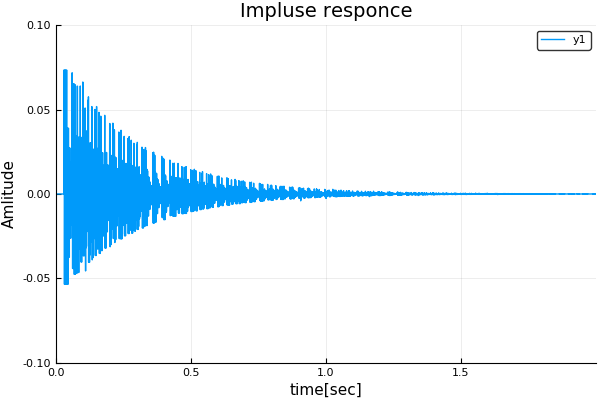

In [10]:
# impulse responce
showIr(reverb)